In [1]:
from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

%matplotlib inline

In [2]:
raw_data = np.random.randint(0, 255, (3, 100))

In [3]:
network_dimensions = np.array([5, 5])
n_iterations = 10000
init_learning_rate = 0.01

normalise_data = True
normalise_by_column = False

In [4]:
m = raw_data.shape[0]
n = raw_data.shape[1]

# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

data = raw_data
if normalise_data:
    if normalise_by_column:
        col_maxes = raw_data.max(axis=0)
        data = raw_data / col_maxes[np.newaxis, :]
    else:
        data = raw_data / data.max()


In [5]:
net = np.random.random((network_dimensions[0], network_dimensions[1], m))

In [6]:
def find_bmu(t, net, m):
    """
        Find the best matching unit for a given vector, t
        Returns: bmu and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    min_dist = np.iinfo(np.int).max
    
    # calculate the distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            sq_dist = np.sum((w - t) ** 2)
            sq_dist = np.sqrt(sq_dist)
            if sq_dist < min_dist:
                min_dist = sq_dist # dist
                bmu_idx = np.array([x, y]) # id
    
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    return (bmu, bmu_idx)


In [7]:
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

In [8]:
for i in range(n_iterations):
    # select a training example at random
    t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))
    
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    
    # decay the SOM parameters
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    
    # update weight vector to move closer to input
    # and move its neighbours in 2-D vector space closer
    
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            w_dist = np.sqrt(w_dist)
            
            if w_dist <= r:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                net[x, y, :] = new_w.reshape(1, 3)

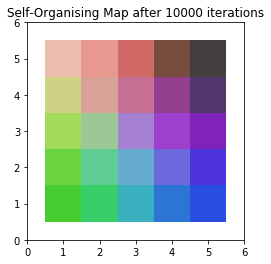

In [9]:
fig = plt.figure()

ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, net.shape[0]+1))
ax.set_ylim((0, net.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

# plot
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none'))
plt.show()